In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from torch.nn import functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from torch_geometric.data import Dataset, Data, DataLoader
import pickle
import os



In [21]:
def load_data(save_dir):
    graphs = []
    for file in os.listdir(save_dir):
        if file.endswith(".pt"):
            graphs.append(torch.load(f'{save_dir}/{file}'))
    return graphs

save_dir = "./datanew/Data/saved_graphs_2/train"
train_pg_subgraph = load_data(save_dir)

save_dir = "./datanew/Data/saved_graphs_2/val"
val_pg_subgraph = load_data(save_dir)

save_dir = "./datanew/Data/saved_graphs_2/test"
test_pg_subgraph = load_data(save_dir)

C:\Users\Büşra\AppData\Local\Temp\ipykernel_1372\2775338884.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graphs.append(torch.load(f'{save_dir}/{file}'))


In [22]:
## To get the number of true gene and set true gene as data.y label
all_true_gene_ids = []

for patient in train_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

for patient in val_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)
    
for patient in test_pg_subgraph:
    all_true_gene_ids.extend(patient.true_gene_ids)

## Get the unique true gene ids
unique_true_gene_ids = set(all_true_gene_ids)
print("the number of unique true gene ids is:",len(unique_true_gene_ids))

## Mapping all unique true gene ids to a index from 0 to the number of unique true gene ids
gene_id_mapping = {gene_id: idx for idx, gene_id in enumerate(unique_true_gene_ids)}
print(gene_id_mapping)

## Add the true gene ids back to the graph
for patient in train_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in val_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

for patient in test_pg_subgraph:
    patient.y = torch.tensor([gene_id_mapping[gene_id] for gene_id in patient.true_gene_ids], dtype=torch.long)

print(train_pg_subgraph[0].true_gene_ids)
print(train_pg_subgraph[0].y)

print(val_pg_subgraph[0].true_gene_ids)
print(val_pg_subgraph[0].y)

print(test_pg_subgraph[0].true_gene_ids)
print(test_pg_subgraph[0].y)

the number of unique true gene ids is: 2405
{4: 0, 10: 1, 8204: 2, 8208: 3, 8210: 4, 18: 5, 22: 6, 23: 7, 29: 8, 30: 9, 8224: 10, 33: 11, 37: 12, 8231: 13, 41: 14, 42: 15, 8234: 16, 43: 17, 8246: 18, 61: 19, 67: 20, 8266: 21, 74: 22, 8268: 23, 78: 24, 80: 25, 83: 26, 85: 27, 87: 28, 88: 29, 8281: 30, 8283: 31, 8284: 32, 92: 33, 95: 34, 97: 35, 98: 36, 100: 37, 111: 38, 8305: 39, 8318: 40, 130: 41, 133: 42, 143: 43, 144: 44, 146: 45, 150: 46, 8345: 47, 154: 48, 162: 49, 163: 50, 57507: 51, 57506: 52, 169: 53, 8362: 54, 173: 55, 177: 56, 178: 57, 8371: 58, 8372: 59, 57521: 60, 8376: 61, 8378: 62, 187: 63, 8379: 64, 8388: 65, 8395: 66, 207: 67, 209: 68, 212: 69, 213: 70, 8405: 71, 8411: 72, 8416: 73, 8422: 74, 232: 75, 8428: 76, 238: 77, 8434: 78, 242: 79, 8437: 80, 246: 81, 8439: 82, 245: 83, 249: 84, 57595: 85, 8446: 86, 256: 87, 8454: 88, 8456: 89, 8458: 90, 8462: 91, 8464: 92, 57618: 93, 8466: 94, 276: 95, 279: 96, 8473: 97, 8477: 98, 288: 99, 8480: 100, 57632: 101, 291: 102, 8483: 10

In [23]:
## Preprocess the trainign data, extract only x, y, edge_index

from torch_geometric.data import Data

def preprocess_graph_data(dataset):
    processed_graphs = []
   
    for data in dataset:
        
        new_data = Data(
            edge_index=data.edge_index,
            y=data.y,
            x=data.x,
            original_ids = data.original_ids,
            edge_attr=data.edge_attr
        )
        processed_graphs.append(new_data)
    
    return processed_graphs

train_data = preprocess_graph_data(train_pg_subgraph)
val_data = preprocess_graph_data(val_pg_subgraph)
test_data = preprocess_graph_data(test_pg_subgraph)

In [24]:
## Define collate function for handling batched data
def optimized_collate_fn(batch):

    batch_size = len(batch)
    cumsum_nodes = 0
    
    # Adjust edge indices to account for the node offset in each batch
    adjusted_edge_indices = []
    for data in batch:
        edge_index = data.edge_index + cumsum_nodes
        adjusted_edge_indices.append(edge_index)
        cumsum_nodes += data.num_nodes

    # Concatenate with adjusted indices
    x = torch.cat([data.x for data in batch], dim=0)
    y = torch.cat([data.y for data in batch], dim=0)
    edge_index = torch.cat(adjusted_edge_indices, dim=1)
    edge_attr = torch.cat([data.edge_attr for data in batch], dim=0) if batch[0].edge_attr is not None else None
    batch_tensor = torch.cat([torch.full((data.num_nodes,), i, dtype=torch.long) for i, data in enumerate(batch)])
    
    ## Additional attributes
    original_ids = torch.cat([torch.tensor(data.original_ids, dtype=torch.long) if isinstance(data.original_ids, list) else data.original_ids for data in batch if data.original_ids is not None])
    
    return Data(
        x = x,
        y = y,
        edge_index=edge_index,
        edge_attr=edge_attr,
        batch=batch_tensor,
        original_ids=original_ids,
        batch_size=batch_size,
      
    )
## torch.dataloader doesn't consider custom data types
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=optimized_collate_fn)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=optimized_collate_fn)
test_loader = DataLoader(test_data, batch_size=128, collate_fn=optimized_collate_fn)


In [69]:
import torch.nn as nn
import torch.optim as optim
class NodeLevelModule(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, hidden_dim, out_dim):
        super(NodeLevelModule, self).__init__()
        self.global_node_embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=embedding_dim)
        self.conv1 = GCNConv(embedding_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, out_dim)

    def forward(self, data):
        # Ensure original_ids is a tensor
        if isinstance(data.original_ids, list):
            # Flatten list and convert to tensor
            data.original_ids = torch.cat([torch.tensor(ids, dtype=torch.long) for ids in data.original_ids])
        data.original_ids = data.original_ids.to(data.x.device)

        x = self.global_node_embedding(data.original_ids)
        x = self.conv1(x, data.edge_index)
        x = F.relu(x)
        x = self.conv2(x, data.edge_index)
        return x  # Node embeddings

In [70]:
class PopulationLevelModule(nn.Module):
    def __init__(self, graph_dim, latent_dim):
        super(PopulationLevelModule, self).__init__()
        self.latent_project = nn.Linear(graph_dim, latent_dim)
        self.theta = nn.Parameter(torch.randn(1))  # Learnable threshold

    def forward(self, graph_representations):
        h_tilde = self.latent_project(graph_representations)
        similarity = torch.cdist(h_tilde, h_tilde, p=2)
        adjacency_matrix = 1 / (1 + torch.exp(-self.theta * similarity))
        return adjacency_matrix


In [71]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from torch_geometric.data import DataLoader

class GNNClusteringModule(nn.Module):
    def __init__(self, graph_dim, embedding_dim, dropout=0.3):
        super(GNNClusteringModule, self).__init__()

        self.fc1 = nn.Linear(graph_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, embedding_dim)  # Output a lower-dim embedding for clustering

        self.dropout = nn.Dropout(dropout)

    def forward(self, graph_repr, population_graph):
        """
        :param graph_repr: Graph-level embeddings from F1
        :param population_graph: Learned adjacency matrix from F2
        :return: Patient embeddings for clustering
        """
        x = F.relu(self.bn1(self.fc1(graph_repr)))
        x = self.dropout(x)
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)
        patient_embeddings = self.fc3(x)  # Shape: [batch_size, embedding_dim]

        return patient_embeddings



In [72]:
def clustering_loss(patient_embeddings, batch_y):
    """
    Contrastive Loss for clustering similar patients
    :param patient_embeddings: Output embeddings from F3
    :param batch_y: True gene labels for patients (shape: [batch_size])
    :return: Loss for optimizing clustering
    """
    batch_size = patient_embeddings.shape[0]

    # Compute pairwise similarity (cosine similarity)
    similarity_matrix = torch.mm(patient_embeddings, patient_embeddings.T)  # [batch_size, batch_size]

    # Normalize the similarity scores
    similarity_matrix = F.normalize(similarity_matrix, p=2, dim=1)

    # Create a target similarity matrix based on labels
    target_similarity = (batch_y.unsqueeze(0) == batch_y.unsqueeze(1)).float()

    # Compute Mean Squared Error loss
    loss = F.mse_loss(similarity_matrix, target_similarity)

    return loss


In [73]:
def contrastive_loss(cluster_labels, true_gene_ids):
    """
    Ensure patients with the same true gene ID are clustered together.
    """
    loss = 0
    for i in range(len(cluster_labels)):
        for j in range(i + 1, len(cluster_labels)):
            same_cluster = (cluster_labels[i] == cluster_labels[j]).float()
            same_gene = (true_gene_ids[i] == true_gene_ids[j]).float()
            loss += torch.abs(same_cluster - same_gene)

    return loss / (len(cluster_labels) ** 2)


In [74]:
def node_degree_distribution_loss(Ap, target_mean=7, target_std=2):
    degrees = Ap.sum(dim=1)  # Compute node degrees
    target_distribution = torch.normal(mean=target_mean, std=target_std, size=(Ap.shape[0],)).to(Ap.device)
    return F.mse_loss(degrees, target_distribution)



In [75]:
import matplotlib.pyplot as plt

def plot_adjacency_matrix(Ap, epoch):
    """ Function to plot adjacency matrix """
    Ap = Ap.detach().cpu().numpy()  # Convert to NumPy
    plt.figure(figsize=(6, 6))
    plt.imshow(Ap, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    plt.title(f"Adjacency Matrix - Epoch {epoch}")
    plt.xlabel("Nodes")
    plt.ylabel("Nodes")
    plt.show()


In [82]:
import numpy as np
import torch.nn.functional as F
import torch

# ===========================
# UPDATED: Prevent NaN in `evaluate_clustering_model`
# ===========================

def evaluate_clustering_model(f1, f2, f3, data_loader, device):
    f1.eval()
    f2.eval()
    f3.eval()

    total_loss = 0
    all_embeddings, all_labels = [], []

    with torch.no_grad():
        for batch in data_loader:
            batch = batch.to(device)

            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            patient_embeddings = f3(graph_representations, population_graph)

            # ======================
            # FIX: Normalize embeddings to prevent NaNs
            # ======================
            patient_embeddings = F.normalize(patient_embeddings, p=2, dim=1)

            # FIX: If NaN or Inf detected, replace with zeros
            if torch.isnan(patient_embeddings).any() or torch.isinf(patient_embeddings).any():
                print("WARNING: NaN/Inf detected in patient embeddings! Replacing with zeros.")
                patient_embeddings = torch.where(torch.isnan(patient_embeddings) | torch.isinf(patient_embeddings), 
                                                 torch.zeros_like(patient_embeddings), 
                                                 patient_embeddings)

            loss = clustering_loss(patient_embeddings, batch.y)
            total_loss += loss.item()

            all_embeddings.append(patient_embeddings.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    # Convert embeddings to numpy array
    all_embeddings = np.vstack(all_embeddings)

    # ======================
    # FIX: Remove NaN embeddings before KMeans
    # ======================
    nan_mask = ~np.isnan(all_embeddings).any(axis=1)
    filtered_embeddings = all_embeddings[nan_mask]
    filtered_labels = np.array(all_labels)[nan_mask]

    if len(filtered_embeddings) == 0:
        print("ERROR: All embeddings are NaN, skipping clustering.")
        return total_loss

    # Perform Clustering
    kmeans = KMeans(n_clusters=len(set(filtered_labels)), random_state=0).fit(filtered_embeddings)
    predicted_clusters = kmeans.labels_

    # Compute cluster similarity
    cosine_sim = cosine_similarity(filtered_embeddings)

    print(f"Mean Cosine Similarity: {cosine_sim.mean():.4f}")

    return total_loss

# ===========================
# UPDATED: Train Model with Better Stability
# ===========================

def train_clustering_model(train_loader, val_loader, num_epochs=50, lr=0.001, alpha=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    num_embeddings = 105220  # Total unique node IDs
    embedding_dim = 64
    hidden_dim = 128
    out_dim = 32

    f1 = NodeLevelModule(num_embeddings, embedding_dim, hidden_dim, out_dim).to(device)
    f2 = PopulationLevelModule(graph_dim=out_dim, latent_dim=16).to(device)
    f3 = GNNClusteringModule(graph_dim=out_dim, embedding_dim=32).to(device)

    optimizer = optim.AdamW(
        list(f1.parameters()) + list(f2.parameters()) + list(f3.parameters()), 
        lr=lr, weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

    best_val_loss = float("inf")
    patience, patience_counter = 5, 0

    for epoch in range(num_epochs):
        f1.train()
        f2.train()
        f3.train()

        total_loss = 0

        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            patient_embeddings = f3(graph_representations, population_graph)

            # Normalize embeddings before loss
            patient_embeddings = F.normalize(patient_embeddings, p=2, dim=1)

            loss = clustering_loss(patient_embeddings, batch.y) + alpha * node_degree_distribution_loss(population_graph)

            # ======================
            # FIX: Avoid NaN loss
            # ======================
            if torch.isnan(loss) or torch.isinf(loss):
                print("WARNING: NaN/Inf detected in loss! Skipping this batch.")
                continue  # Skip problematic batch

            loss.backward()

            # ======================
            # FIX: Lower gradient clipping max norm
            # ======================
            torch.nn.utils.clip_grad_norm_(f1.parameters(), max_norm=0.5)
            torch.nn.utils.clip_grad_norm_(f2.parameters(), max_norm=0.5)
            torch.nn.utils.clip_grad_norm_(f3.parameters(), max_norm=0.5)

            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}")

        scheduler.step(total_loss)

        # Validation Step
        val_loss = evaluate_clustering_model(f1, f2, f3, val_loader, device)
        print(f"Validation Loss: {val_loss:.4f}")

        # If validation loss explodes, reduce learning rate
        if val_loss > best_val_loss * 2:
            print("🔻 Large jump in loss detected! Reducing learning rate.")
            for param_group in optimizer.param_groups:
                param_group['lr'] *= 0.5  # Reduce LR by 50%

        best_val_loss = min(best_val_loss, val_loss)

        # Early stopping if loss is NaN for multiple epochs
        if torch.isnan(torch.tensor(total_loss)):
            patience_counter += 1
            if patience_counter >= patience:
                print("⛔ Training stopped early due to NaN loss.")
                break


In [83]:
# Define DataLoaders
batch_size = 32  # Adjust based on GPU memory
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, collate_fn=optimized_collate_fn)
val_loader = DataLoader(val_data, batch_size=128, collate_fn=optimized_collate_fn)
test_loader = DataLoader(test_data, batch_size=128, collate_fn=optimized_collate_fn)


print(f"Dataset Loaded: {len(train_data)} Train | {len(val_data)} Validation | {len(test_data)} Test")

Dataset Loaded: 36224 Train | 6400 Validation | 146 Test


C:\anaconda3\envs\graph\Lib\site-packages\torch_geometric\deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [84]:
train_clustering_model(train_loader, val_loader, num_epochs=30, lr=0.01, alpha=0.1)


C:\anaconda3\envs\graph\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Loss: 1580.2574
Mean Cosine Similarity: 0.1338
Validation Loss: 0.6322
Epoch 2/30, Loss: 206.6321
Mean Cosine Similarity: 0.0691
Validation Loss: 0.5933
Epoch 3/30, Loss: 189.4329
Mean Cosine Similarity: 0.0902
Validation Loss: 0.6032
Epoch 4/30, Loss: 173.0410
Mean Cosine Similarity: 0.0706
Validation Loss: 0.5900
Epoch 5/30, Loss: 167.1252
Mean Cosine Similarity: 0.0745
Validation Loss: 0.5895
Epoch 6/30, Loss: 164.0663
Mean Cosine Similarity: 0.0671
Validation Loss: 0.5929
Epoch 7/30, Loss: 193.8987
Mean Cosine Similarity: 0.0904
Validation Loss: 0.6156
Epoch 8/30, Loss: 15721.7958
Mean Cosine Similarity: 0.1254
Validation Loss: 0.6629
Epoch 9/30, Loss: 46203.9474
Mean Cosine Similarity: 0.1772
Validation Loss: 0.6874
Epoch 10/30, Loss: 2799.6747
Mean Cosine Similarity: 0.2421
Validation Loss: 0.7016
Epoch 11/30, Loss: 10823.9062


C:\anaconda3\envs\graph\Lib\site-packages\sklearn\base.py:1473: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (499). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Mean Cosine Similarity: 0.0000
Validation Loss: 0.5464


KeyboardInterrupt: 

C:\anaconda3\envs\graph\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/30, Loss: 31092.0106, Accuracy: 0.0105


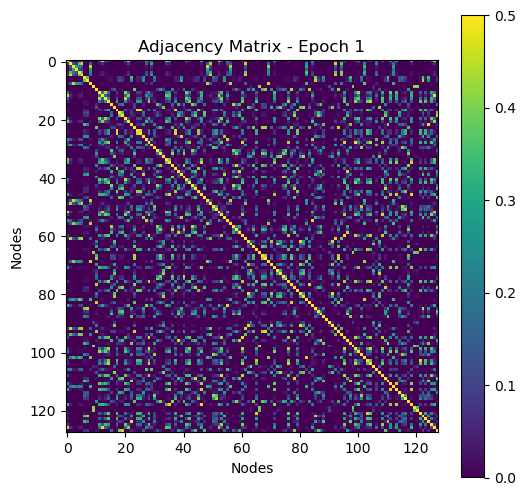

Validation Loss: 442.5968, Accuracy: 0.0128, F1-score: 0.0006
Epoch 2/30, Loss: 2155.1474, Accuracy: 0.0161


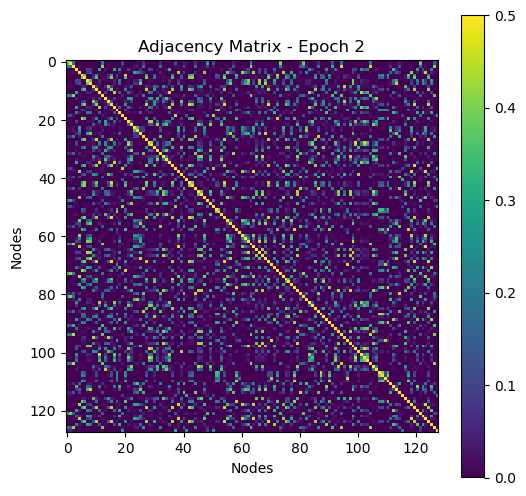

Validation Loss: 481.0041, Accuracy: 0.0075, F1-score: 0.0005
Epoch 3/30, Loss: 2031.5452, Accuracy: 0.0204


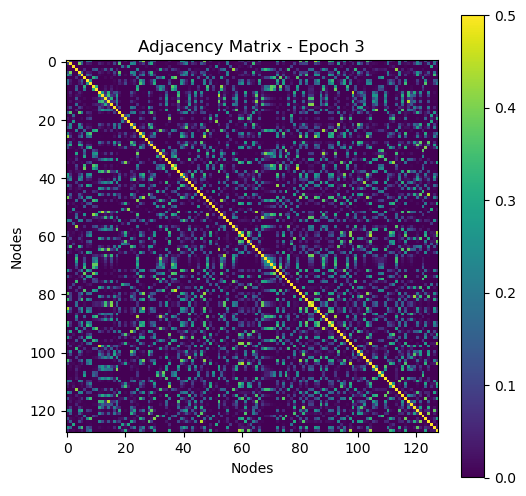

Validation Loss: 493.1863, Accuracy: 0.0120, F1-score: 0.0017
Epoch 4/30, Loss: 1941.8165, Accuracy: 0.0246


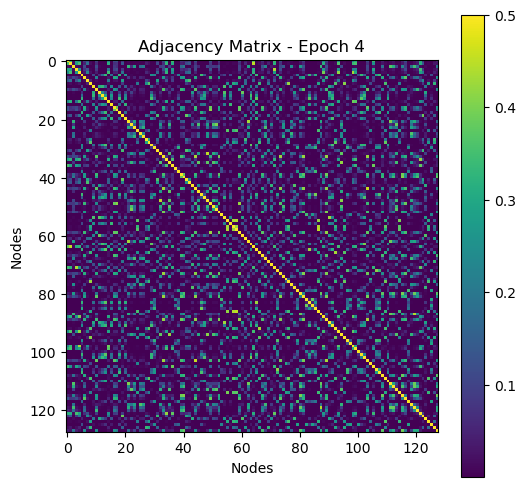

Validation Loss: 513.9470, Accuracy: 0.0106, F1-score: 0.0017
Epoch 5/30, Loss: 1883.9770, Accuracy: 0.0313


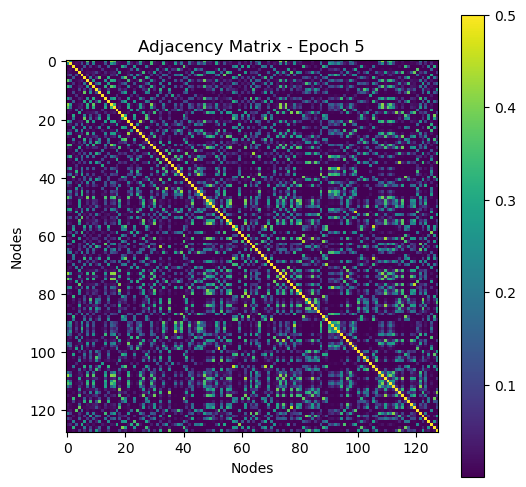

Validation Loss: 532.3922, Accuracy: 0.0112, F1-score: 0.0021
Epoch 6/30, Loss: 1841.6681, Accuracy: 0.0359


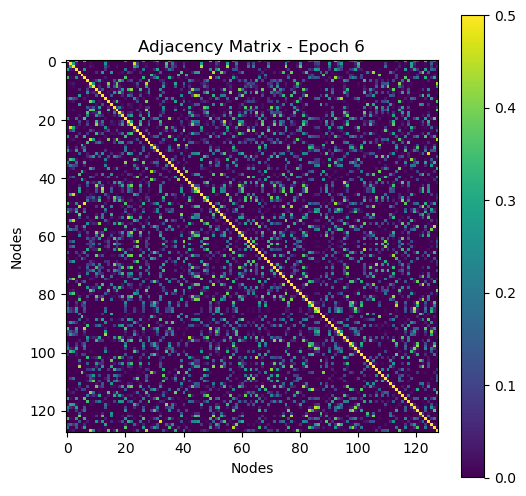

Validation Loss: 550.7341, Accuracy: 0.0180, F1-score: 0.0022
Epoch 7/30, Loss: 1813.2696, Accuracy: 0.0415


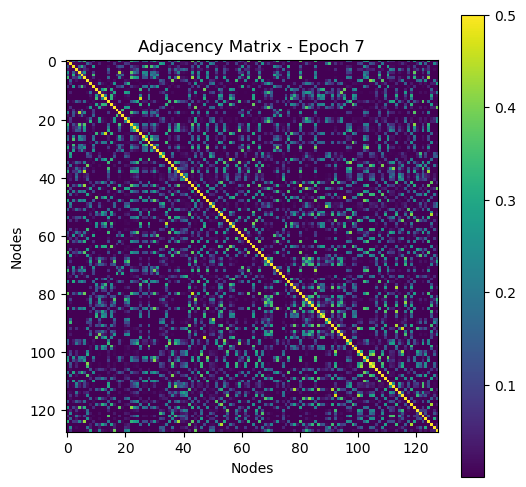

Validation Loss: 567.9038, Accuracy: 0.0178, F1-score: 0.0029
Epoch 8/30, Loss: 1886.1841, Accuracy: 0.0435


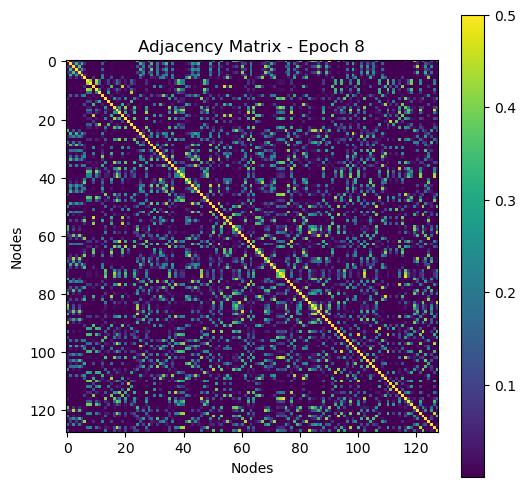

Validation Loss: 538.5786, Accuracy: 0.0172, F1-score: 0.0035
Epoch 9/30, Loss: 8826.6560, Accuracy: 0.0409


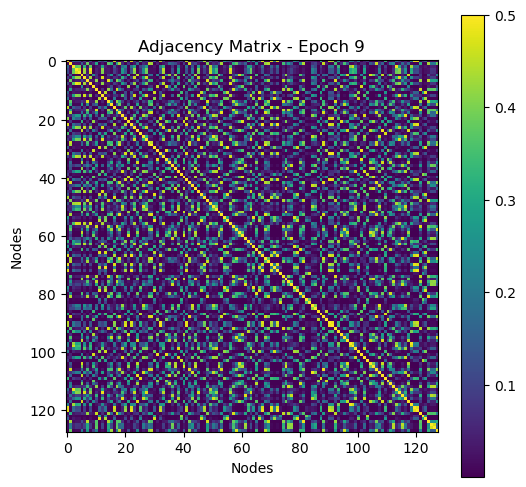

Validation Loss: 541.3067, Accuracy: 0.0144, F1-score: 0.0032
Epoch 10/30, Loss: nan, Accuracy: 0.0079


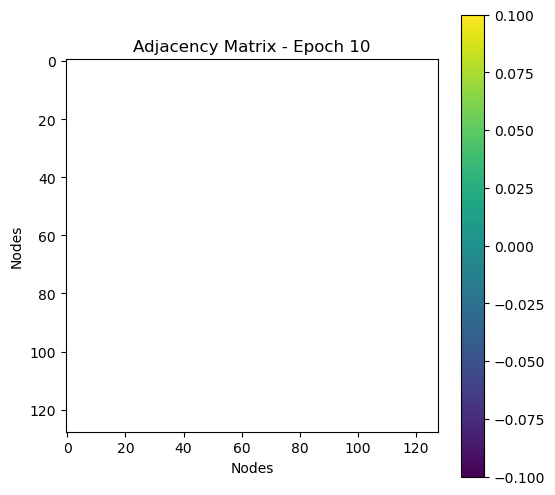

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 11/30, Loss: nan, Accuracy: 0.0004


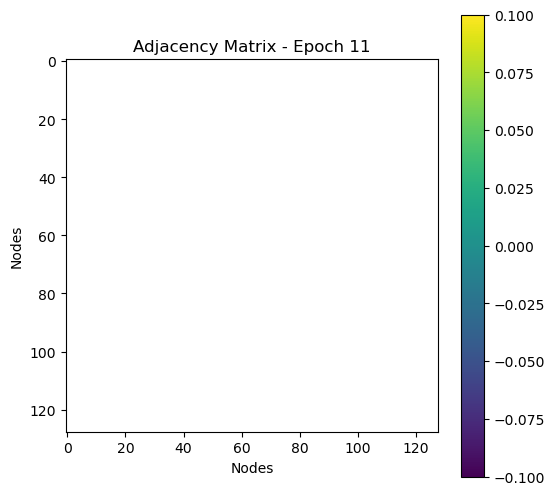

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 12/30, Loss: nan, Accuracy: 0.0004


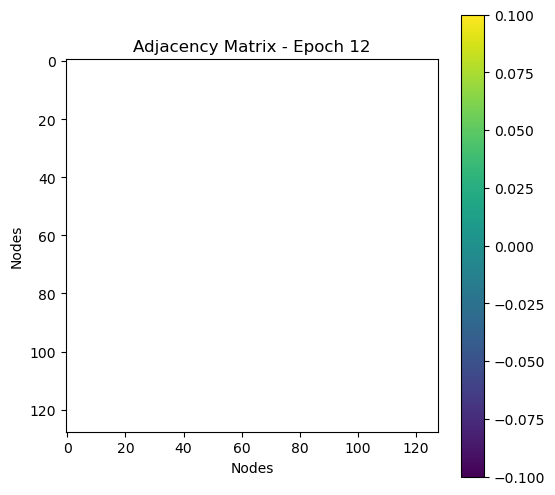

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 13/30, Loss: nan, Accuracy: 0.0004


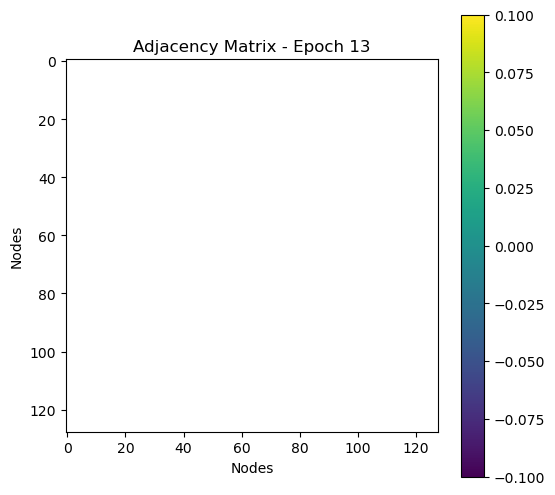

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 14/30, Loss: nan, Accuracy: 0.0004


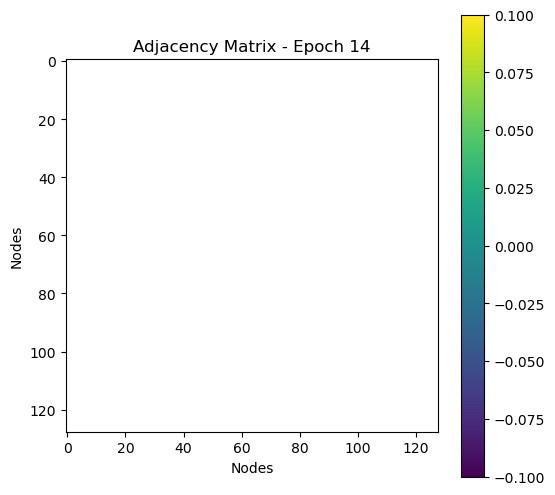

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 15/30, Loss: nan, Accuracy: 0.0004


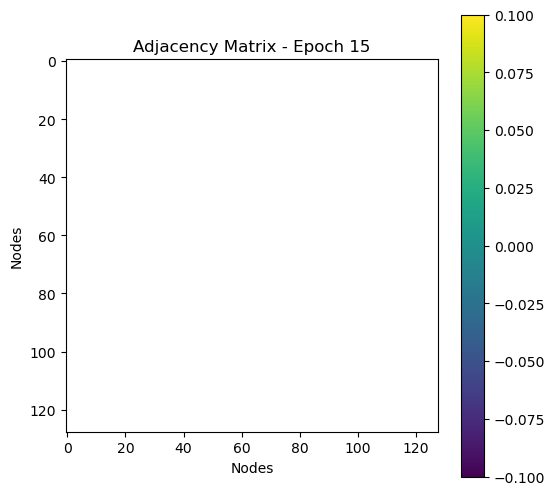

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000
Epoch 16/30, Loss: nan, Accuracy: 0.0004


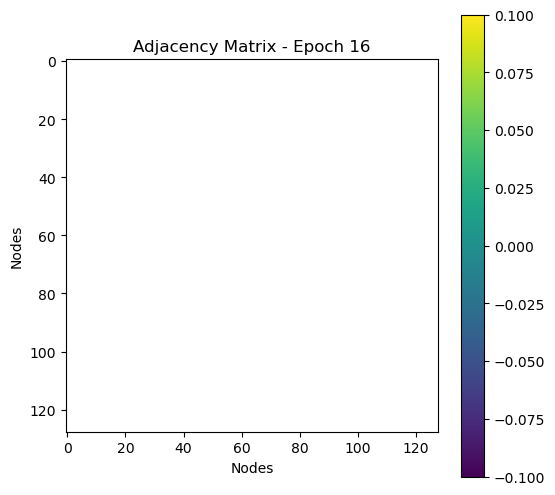

Validation Loss: nan, Accuracy: 0.0000, F1-score: 0.0000


KeyboardInterrupt: 

In [93]:
def test_model(f1, f2, f3, test_loader, criterion, device):
    f1.eval()
    f2.eval()
    f3.eval()
    
    total_loss, total_correct, total_samples = 0, 0, 0
    all_preds, all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            batch = batch.to(device)
            node_embeddings = f1(batch)
            graph_representations = global_mean_pool(node_embeddings, batch.batch)
            population_graph = f2(graph_representations)
            outputs = f3(graph_representations, population_graph)
            
            loss = criterion(outputs, batch.y)
            total_loss += loss.item()
            
            preds = outputs.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

            total_correct += (preds == batch.y).sum().item()
            total_samples += batch.y.size(0)

    acc = total_correct / total_samples
    f1_macro = f1_score(all_labels, all_preds, average="macro")

    print(f"\n🔥 Test Results: Loss={total_loss:.4f} | Accuracy={acc:.4f} | F1-score={f1_macro:.4f}\n")
    
    return total_loss, acc, f1_macro


In [96]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


f1 = NodeLevelModule(num_embeddings=105220, embedding_dim=64, hidden_dim=128, out_dim=32).to(device)
# Load trained models
f2 = PopulationLevelModule(graph_dim=32, latent_dim=16).to(device)
f3 = GNNClassifier(graph_dim=32, num_classes=2405).to(device)

# Load best weights if saved (Optional)
# f1.load_state_dict(torch.load("f1_best.pth"))
# f2.load_state_dict(torch.load("f2_best.pth"))
# f3.load_state_dict(torch.load("f3_best.pth"))

criterion = nn.CrossEntropyLoss()

# Run testing
test_model(f1, f2, f3, test_loader, criterion, device)


ValueError: not enough values to unpack (expected 2, got 0)

In [ ]:
# Save
torch.save(f1.state_dict(), "f1_best.pth")
torch.save(f2.state_dict(), "f2_best.pth")
torch.save(f3.state_dict(), "f3_best.pth")

# Load later
f1.load_state_dict(torch.load("f1_best.pth"))
f2.load_state_dict(torch.load("f2_best.pth"))
f3.load_state_dict(torch.load("f3_best.pth"))
